# CS470/CS670 Team 6 Final Project: Proposal for Pneumonia Detection Using Chest X-Ray Images

In [ ]:
# Import required libraries
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2,ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [ ]:
# Download dataset using kagglehub
import kagglehub
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print(f"Dataset downloaded to: {dataset_path}")

# Print directory structure
for root, dirs, files in os.walk(dataset_path):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)


100%|██████████| 2.29G/2.29G [00:29<00:00, 84.5MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Subdirectories: ['chest_xray']
Files: []
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray
Subdirectories: ['val', 'train', '__MACOSX', 'chest_xray', 'test']
Files: []
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val
Subdirectories: ['NORMAL', 'PNEUMONIA']
Files: []
----------------------------------------
Directory: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val/NORMAL
Subdirectories: []
Files: ['NORMAL2-IM-1438-0001.jpeg', 'NORMAL2-IM-1436-0001.jpeg', 'NORMAL2-IM-1430-0001.jpeg', 'NORMAL2-IM-1442-0001.jpeg', 'NORMAL2-IM-1440-0001.jpeg', 'NORMAL2-IM-

In [ ]:
# Prepare training data
def prepare_dataset(data_dir):
    filepaths, labels = [], []
    for category in os.listdir(data_dir):
        category_path = os.path.join(data_dir, category)
        for img_file in os.listdir(category_path):
            filepaths.append(os.path.join(category_path, img_file))
            labels.append(category)
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

train_dir = os.path.join(dataset_path, "chest_xray/train")
test_dir = os.path.join(dataset_path, "chest_xray/test")

df_train = prepare_dataset(train_dir)
df_test = prepare_dataset(test_dir)


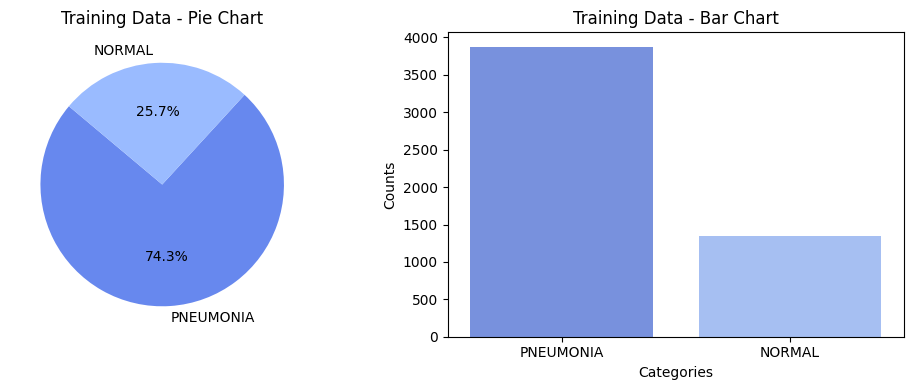

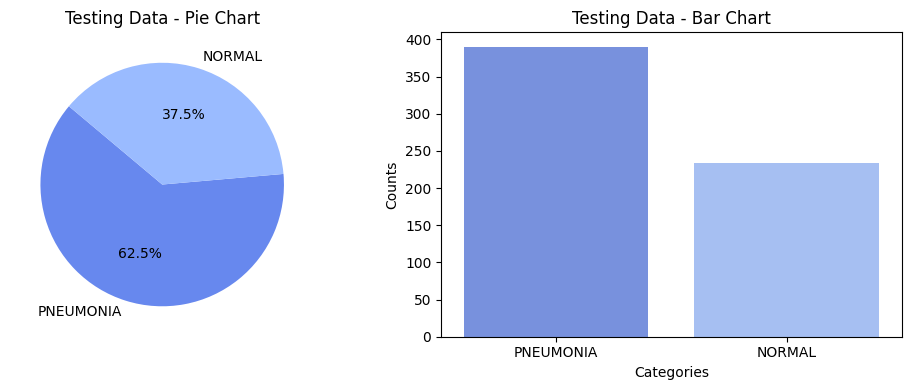

In [ ]:
# Visualize label distribution
def plot_label_distribution(df, title):
    label_counts = df['label'].value_counts()
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), facecolor='white')
    palette = sns.color_palette("coolwarm")

    # Pie chart
    axs[0].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=palette)
    axs[0].set_title(f'{title} - Pie Chart')

    # Bar chart
    sns.barplot(x=label_counts.index, y=label_counts.values, ax=axs[1], palette=palette)
    axs[1].set_title(f'{title} - Bar Chart')
    axs[1].set_xlabel('Categories')
    axs[1].set_ylabel('Counts')

    plt.tight_layout()
    plt.show()

plot_label_distribution(df_train, "Training Data")
plot_label_distribution(df_test, "Testing Data")


In [ ]:
# Image dimensions and batch size
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32

# Create datasets
train_dataset = image_dataset_from_directory(
    train_dir, validation_split=0.1, subset="training", seed=123,
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
val_dataset = image_dataset_from_directory(
    train_dir, validation_split=0.1, subset="validation", seed=123,
    image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)
test_dataset = image_dataset_from_directory(
    test_dir, seed=123, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE
)

# Normalize pixel values
def normalize_dataset(ds):
    return ds.map(lambda x, y: (x / 255.0, y))

train_dataset = normalize_dataset(train_dataset)
val_dataset = normalize_dataset(val_dataset)
test_dataset = normalize_dataset(test_dataset)


Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Found 624 files belonging to 2 classes.


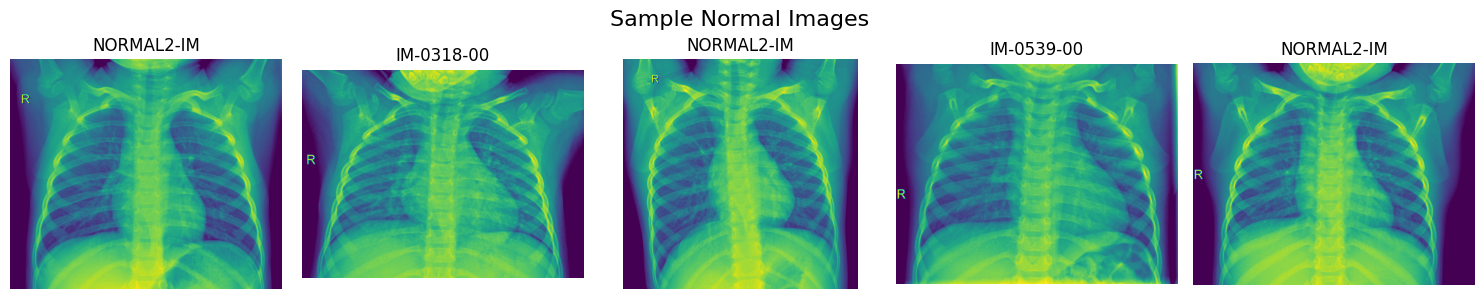

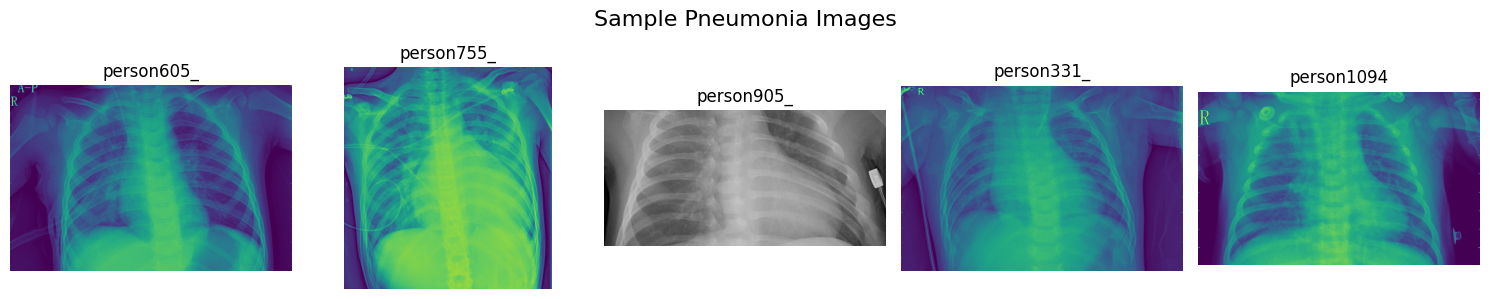

In [ ]:
# Visualize images from a given directory
def visualize_sample_images(data_dir, title, num_images=5):
    image_paths = os.listdir(data_dir)[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')
    for i, img_file in enumerate(image_paths):
        img = plt.imread(os.path.join(data_dir, img_file))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(img_file[:10])  # Show partial filename
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_sample_images(os.path.join(train_dir, "NORMAL"), "Sample Normal Images")
visualize_sample_images(os.path.join(train_dir, "PNEUMONIA"), "Sample Pneumonia Images")


In [ ]:
# Define model
def build_model(input_shape):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model((*IMAGE_SIZE, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train model
history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=15, callbacks=[early_stopping]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 63s 346ms/step - accuracy: 0.8821 - loss: 3.8925 - val_accuracy: 0.9635 - val_loss: 0.0807
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 61s 262ms/step - accuracy: 0.9878 - loss: 0.0337 - val_accuracy: 0.9750 - val_loss: 0.1022
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 255ms/step - accuracy: 0.9961 - loss: 0.0114 - val_accuracy: 0.9866 - val_loss: 0.0463
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.9990 - loss: 0.0033 - val_accuracy: 0.9866 - val_loss: 0.0530
Epoch 5/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 255ms/step - accuracy: 1.0000 - loss: 8.0225e-04 - val_accuracy: 0.9866 - val_loss: 0.0534
Epoch 6/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 45s 307ms/step - accuracy: 1.0000 - loss: 4.5791e-04 - val_accuracy: 0.9846 - val_loss: 0.0542


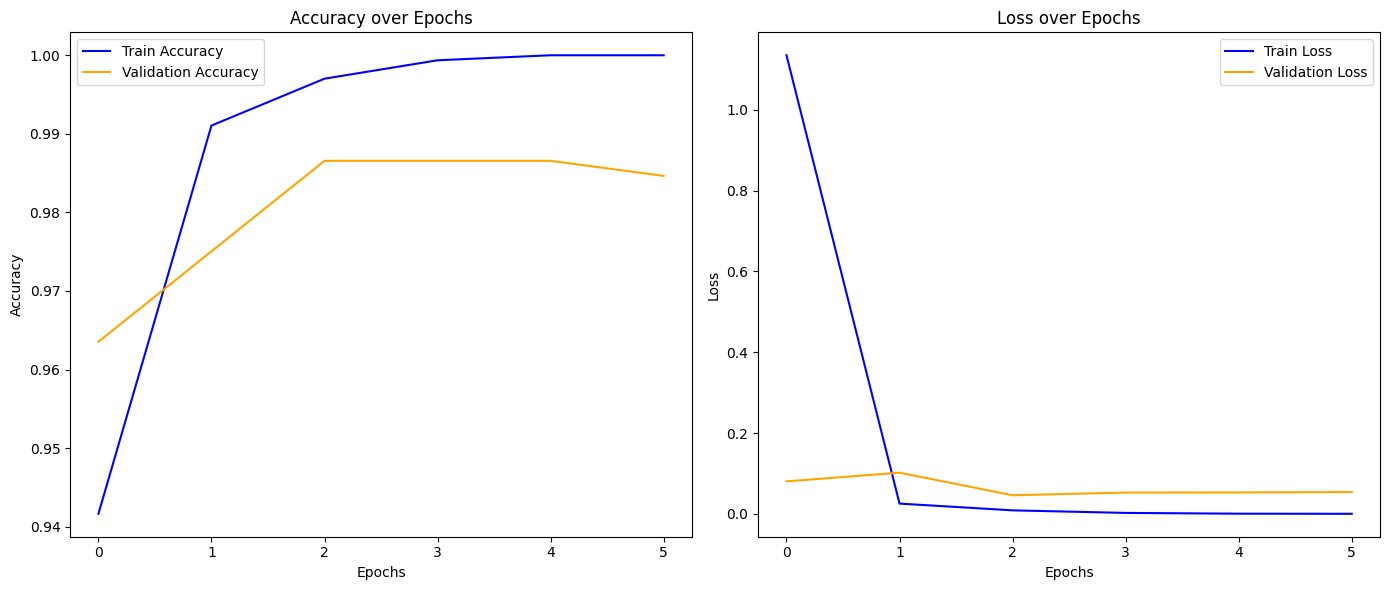

In [ ]:
# Plot training accuracy and loss
def plot_training_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')

    # Accuracy plot
    axs[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
    axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    axs[0].set_title('Accuracy over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()

    # Loss plot
    axs[1].plot(history.history['loss'], label='Train Loss', color='blue')
    axs[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
    axs[1].set_title('Loss over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Loss')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [ ]:
# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 406ms/step - accuracy: 0.8153 - loss: 0.9757
Test Accuracy: 0.80


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 63s 339ms/step - accuracy: 0.6596 - loss: 2.6617 - val_accuracy: 0.7639 - val_loss: 0.6699
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 66s 270ms/step - accuracy: 0.7496 - loss: 0.6653 - val_accuracy: 0.7639 - val_loss: 0.6446
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 42s 277ms/step - accuracy: 0.7450 - loss: 0.6432 - val_accuracy: 0.7639 - val_loss: 0.6230
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 276ms/step - accuracy: 0.7492 - loss: 0.6234 - val_accuracy: 0.7639 - val_loss: 0.6054
Epoch 5/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 269ms/step - accuracy: 0.7513 - loss: 0.6074 - val_accuracy: 0.7639 - val_loss: 0.5916
Epoch 6/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 41s 268ms/step - accuracy: 0.7491 - loss: 0.5966 - val_accuracy: 0.7639 - val_loss: 0.5808
Epoch 7/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 40s 270ms/step - accuracy: 0.7502 - loss: 0.5869 - val_accuracy: 0.7639 - val_loss: 0.5725
Epoch 8/15
147/147 ━━━━━━━━━━━━━

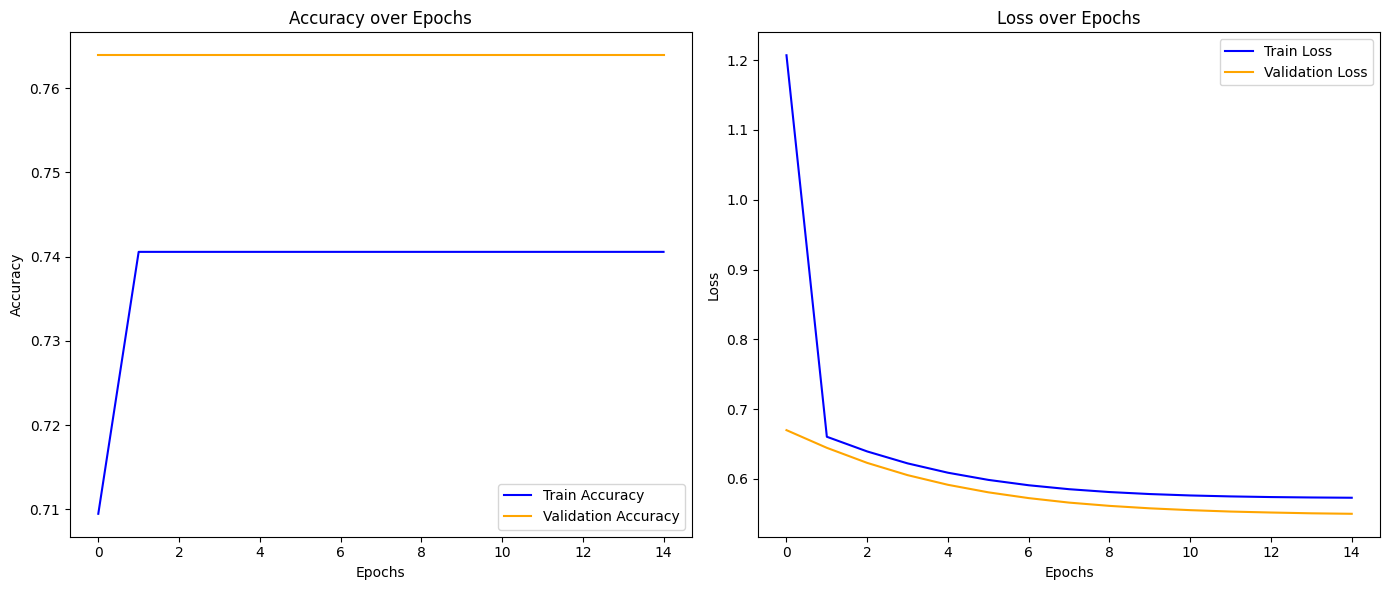

In [ ]:
def build_model(input_shape):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")

    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model((*IMAGE_SIZE, 3))

# Early stopping callback
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train model
history = model.fit(
    train_dataset, validation_data=val_dataset, epochs=15, callbacks=[early_stopping]
)

plot_training_history(history)

In [ ]:
# Evaluate on test dataset
model.summary()
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.2f}")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      16,777,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,920,133 (281.98 MB)

 Trainable params: 16,777,473 (64.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 33,554,948 (128.00 MB)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.6110 - loss: 0.6996
Test Accuracy: 0.62


In [ ]:

def visualize_predictions(model, test_dataset, num_images=5):
    """Visualizes predictions on test images."""

    images, labels = next(iter(test_dataset))  # Get a batch of test images and labels
    predictions = model.predict(images[:num_images])  # Make predictions for the first 'num_images'
    predicted_labels = np.round(predictions).astype(int)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        axes[i].imshow(images[i])
        axes[i].axis('off')
        true_label = int(labels[i])  # Convert label to integer for comparison
        predicted_label = int(predicted_labels[i])

        title = f"True: {true_label}, Pred: {predicted_label}"
        axes[i].set_title(title, color=('green' if true_label == predicted_label else 'red'))

    plt.tight_layout()
    plt.show()

# Example usage:
visualize_predictions(model, test_dataset)

NameError: name 'model' is not defined